In [1]:
from scprint import scPrint
from scdataloader import Preprocessor

from bengrn import BenGRN, get_sroy_gt, FILEDIR
import scanpy as sc

from anndata.utils import make_index_unique
from bengrn import compute_genie3, get_GT_db
from grnndata import utils as grnutils
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/bitsandbytes/cextension.py:31: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


💡 connected lamindb: jkobject/scprint


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [2]:
genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
NUM_GENES = 5000
MAXCELLS = 1024

# han / full


In [3]:
metrics = {}

In [4]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata = adata[:, adata.var.index.isin(genes)]
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 5520 renamining


filtered out 0 cells, 5520 renamining


Removed 0 genes.


startin QC


Seeing 151 outliers (2.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

In [5]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.highly_variable]

genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 734.93 seconds


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.029342280960043824 
recall:  0.8544366899302094 
random precision: 0.027392895508257013


  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 3081.07it/s]

Area Under Precision-Recall Curve (AUPRC):  0.02915976390645599
EPR: 1.4406568461077904


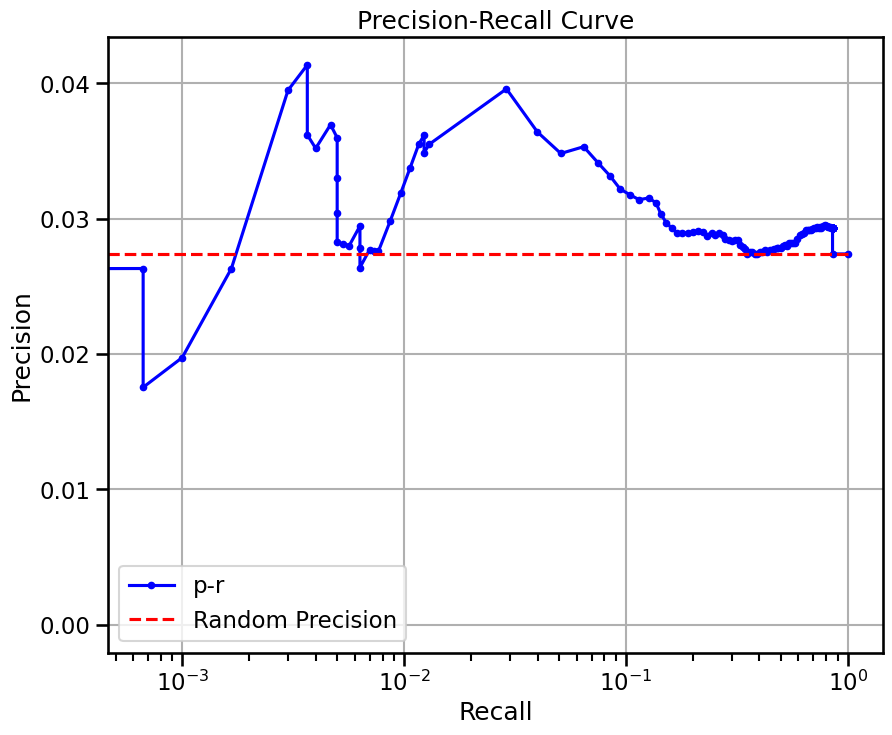

In [6]:
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_han'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


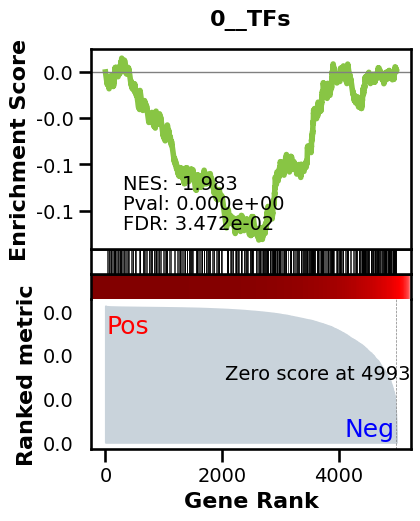

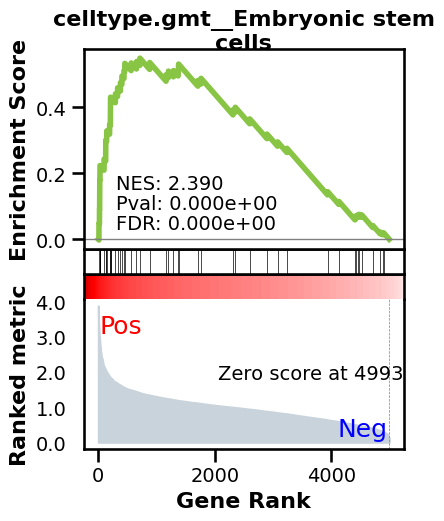

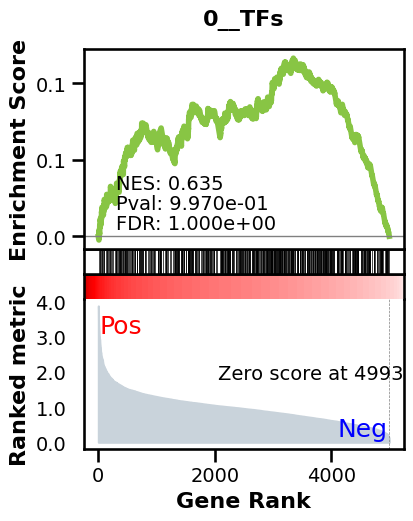

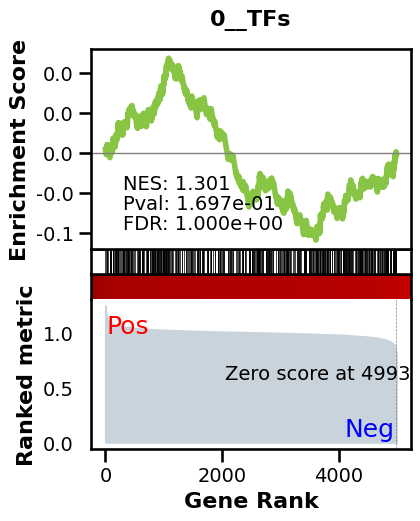

_________________________________________
TF specific enrichment


found some significant results for  11.320754716981131 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3761 genes
intersection pct: 0.7531037244693632
precision:  0.0015467340286693517 
recall:  0.7476461265964389 
random precision: 0.0015171100940786458


  0%|          | 0/128 [00:00<?, ?it/s]

  3%|▎         | 4/128 [00:00<00:03, 39.71it/s]

  6%|▋         | 8/128 [00:00<00:03, 39.49it/s]

  9%|▉         | 12/128 [00:00<00:02, 39.48it/s]

 12%|█▎        | 16/128 [00:00<00:02, 39.43it/s]

 16%|█▌        | 20/128 [00:00<00:02, 39.48it/s]

 19%|█▉        | 24/128 [00:00<00:02, 39.47it/s]

 22%|██▏       | 28/128 [00:00<00:02, 39.45it/s]

 25%|██▌       | 32/128 [00:00<00:02, 39.45it/s]

 28%|██▊       | 36/128 [00:00<00:02, 39.45it/s]

 31%|███▏      | 40/128 [00:01<00:02, 39.50it/s]

 34%|███▍      | 44/128 [00:01<00:02, 39.48it/s]

 38%|███▊      | 48/128 [00:01<00:02, 39.46it/s]

 41%|████      | 52/128 [00:01<00:01, 39.46it/s]

 44%|████▍     | 56/128 [00:01<00:01, 39.45it/s]

 47%|████▋     | 60/128 [00:01<00:01, 39.43it/s]

 50%|█████     | 64/128 [00:01<00:01, 39.45it/s]

 53%|█████▎    | 68/128 [00:01<00:01, 39.26it/s]

 56%|█████▋    | 72/128 [00:01<00:01, 39.23it/s]

 59%|█████▉    | 76/128 [00:01<00:01, 39.35it/s]

 62%|██████▎   | 80/128 [00:02<00:01, 39.38it/s]

 66%|██████▌   | 84/128 [00:02<00:01, 39.51it/s]

 69%|██████▉   | 88/128 [00:02<00:01, 39.62it/s]

 72%|███████▏  | 92/128 [00:02<00:00, 39.66it/s]

 75%|███████▌  | 96/128 [00:02<00:00, 39.73it/s]

 78%|███████▊  | 100/128 [00:02<00:00, 39.76it/s]

 81%|████████▏ | 104/128 [00:02<00:00, 39.81it/s]

 84%|████████▍ | 108/128 [00:02<00:00, 39.71it/s]

 88%|████████▊ | 112/128 [00:02<00:00, 39.64it/s]

 91%|█████████ | 116/128 [00:02<00:00, 39.52it/s]

 94%|█████████▍| 120/128 [00:03<00:00, 39.45it/s]

 97%|█████████▋| 124/128 [00:03<00:00, 39.37it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()


100%|██████████| 128/128 [00:03<00:00, 39.25it/s]

100%|██████████| 128/128 [00:03<00:00, 39.47it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0016742583517634193


EPR: 1.5077820027008297


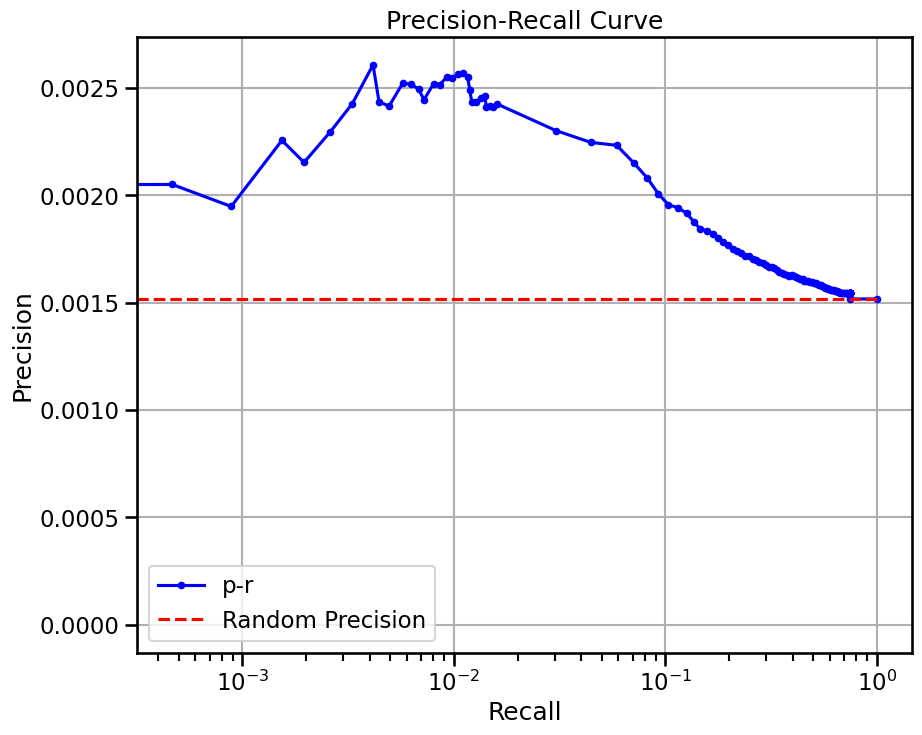

In [7]:
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_han_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.2730288544606347 
recall:  0.9129003061872942 
random precision: 0.25366732938308756


  0%|          | 0/128 [00:00<?, ?it/s]

 47%|████▋     | 60/128 [00:00<00:00, 590.61it/s]

 94%|█████████▍| 120/128 [00:00<00:00, 590.46it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 588.69it/s]

Area Under Precision-Recall Curve (AUPRC):  0.27664613039034436
EPR: 1.2136454863964605


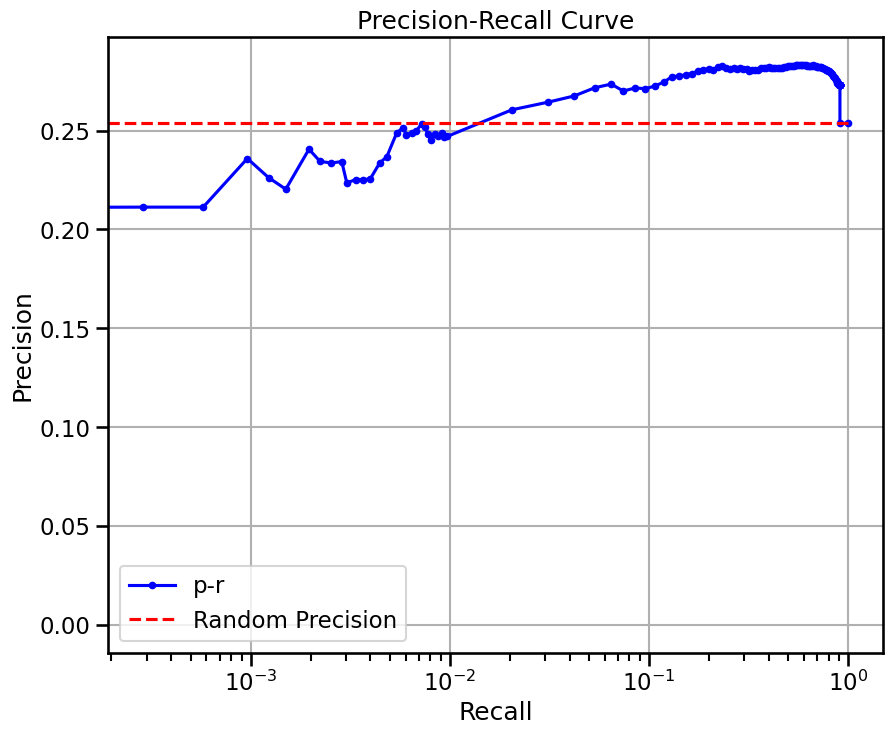

In [8]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_han_chip'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.06953395104411561 
recall:  0.6456990753712525 
random precision: 0.07658579153672285


  0%|          | 0/128 [00:00<?, ?it/s]

 35%|███▌      | 45/128 [00:00<00:00, 441.91it/s]

 70%|███████   | 90/128 [00:00<00:00, 439.11it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 439.56it/s]

Area Under Precision-Recall Curve (AUPRC):  0.07062295330069966
EPR: 0.9949920973929479


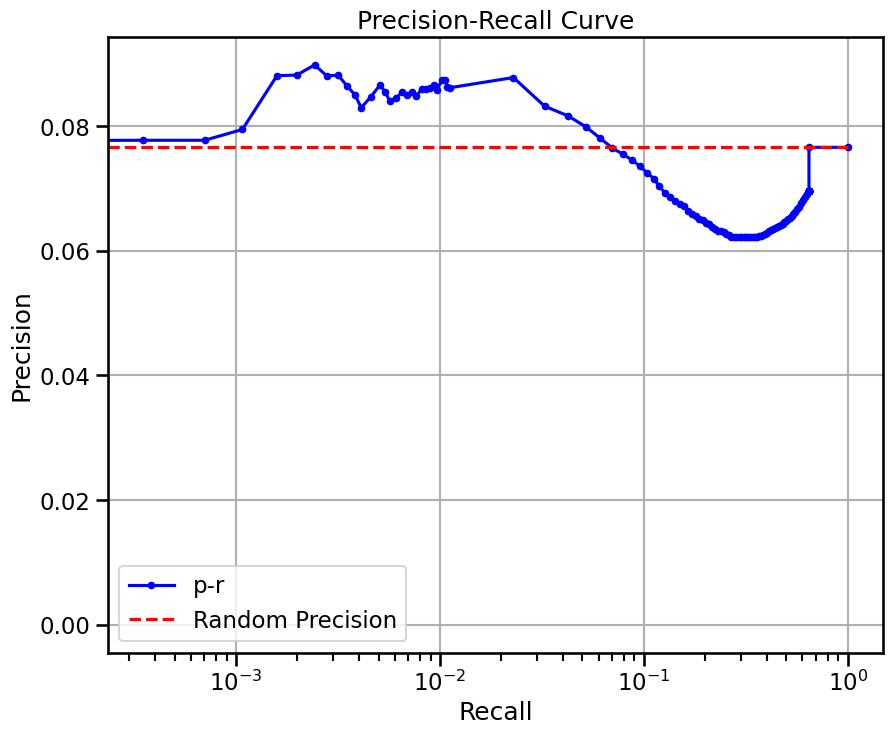

In [9]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['genie3_tf_han_ko'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 157.16 seconds


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.08761967165374394 
recall:  0.1124031007751938 
random precision: 0.07658579153672285


  0%|          | 0/128 [00:00<?, ?it/s]

 35%|███▌      | 45/128 [00:00<00:00, 441.11it/s]

 70%|███████   | 90/128 [00:00<00:00, 441.98it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 441.67it/s]

Area Under Precision-Recall Curve (AUPRC):  0.07749128445450512
EPR: 1.1181298298886302


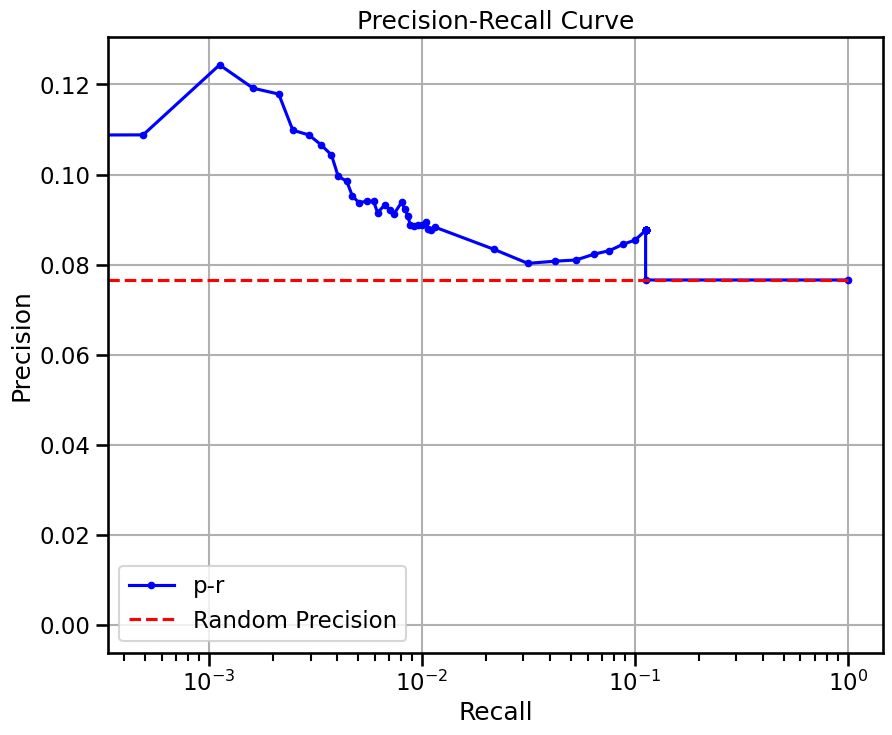

In [10]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]

genie_grn = compute_genie3(subadata, nthreads=20, regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_tf_han'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


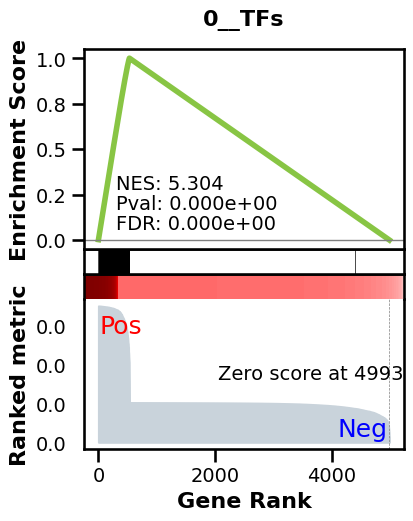

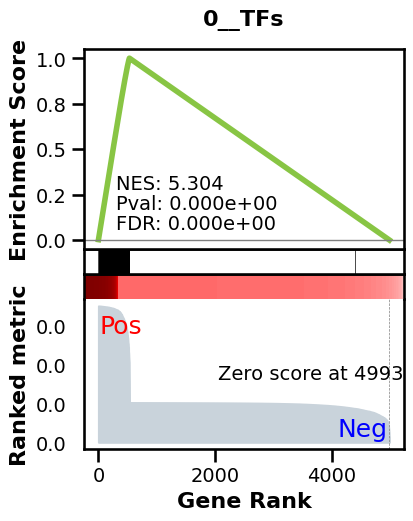

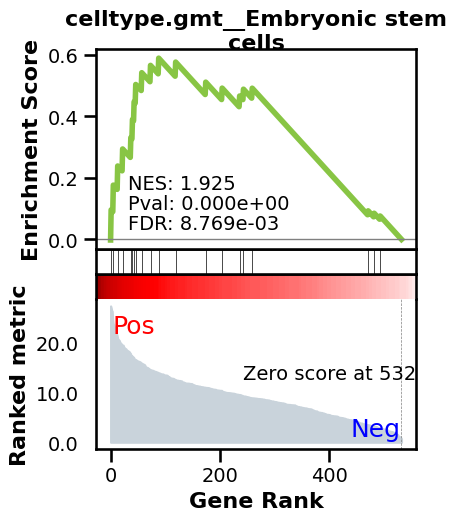

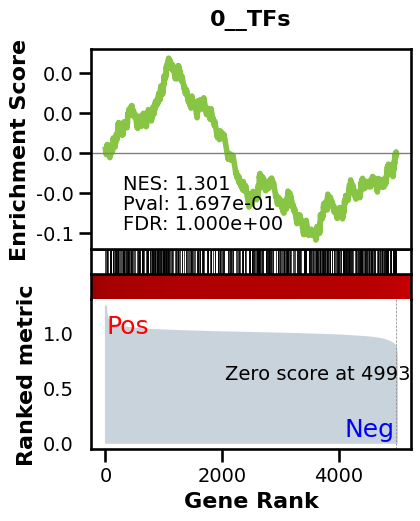

_________________________________________
TF specific enrichment


found some significant results for  15.09433962264151 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3761 genes
intersection pct: 0.7531037244693632
precision:  0.006307904938243491 
recall:  0.5035424629439732 
random precision: 0.0015171100940786458


  0%|          | 0/128 [00:00<?, ?it/s]

  3%|▎         | 4/128 [00:00<00:03, 39.92it/s]

  7%|▋         | 9/128 [00:00<00:02, 40.08it/s]

 11%|█         | 14/128 [00:00<00:02, 40.14it/s]

 15%|█▍        | 19/128 [00:00<00:02, 40.12it/s]

 19%|█▉        | 24/128 [00:00<00:02, 40.09it/s]

 23%|██▎       | 29/128 [00:00<00:02, 40.09it/s]

 27%|██▋       | 34/128 [00:00<00:02, 40.11it/s]

 30%|███       | 39/128 [00:00<00:02, 40.13it/s]

 34%|███▍      | 44/128 [00:01<00:02, 40.06it/s]

 38%|███▊      | 49/128 [00:01<00:01, 40.04it/s]

 42%|████▏     | 54/128 [00:01<00:01, 40.06it/s]

 46%|████▌     | 59/128 [00:01<00:01, 40.03it/s]

 50%|█████     | 64/128 [00:01<00:01, 40.08it/s]

 54%|█████▍    | 69/128 [00:01<00:01, 40.07it/s]

 58%|█████▊    | 74/128 [00:01<00:01, 40.09it/s]

 62%|██████▏   | 79/128 [00:01<00:01, 40.04it/s]

 66%|██████▌   | 84/128 [00:02<00:01, 40.07it/s]

 70%|██████▉   | 89/128 [00:02<00:00, 40.03it/s]

 73%|███████▎  | 94/128 [00:02<00:00, 40.08it/s]

 77%|███████▋  | 99/128 [00:02<00:00, 40.05it/s]

 81%|████████▏ | 104/128 [00:02<00:00, 40.03it/s]

 85%|████████▌ | 109/128 [00:02<00:00, 40.02it/s]

 89%|████████▉ | 114/128 [00:02<00:00, 40.04it/s]

 93%|█████████▎| 119/128 [00:02<00:00, 40.03it/s]

 97%|█████████▋| 124/128 [00:03<00:00, 40.02it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:03<00:00, 40.05it/s]

Area Under Precision-Recall Curve (AUPRC):  0.004684918809324256
EPR: 9.031160238233886


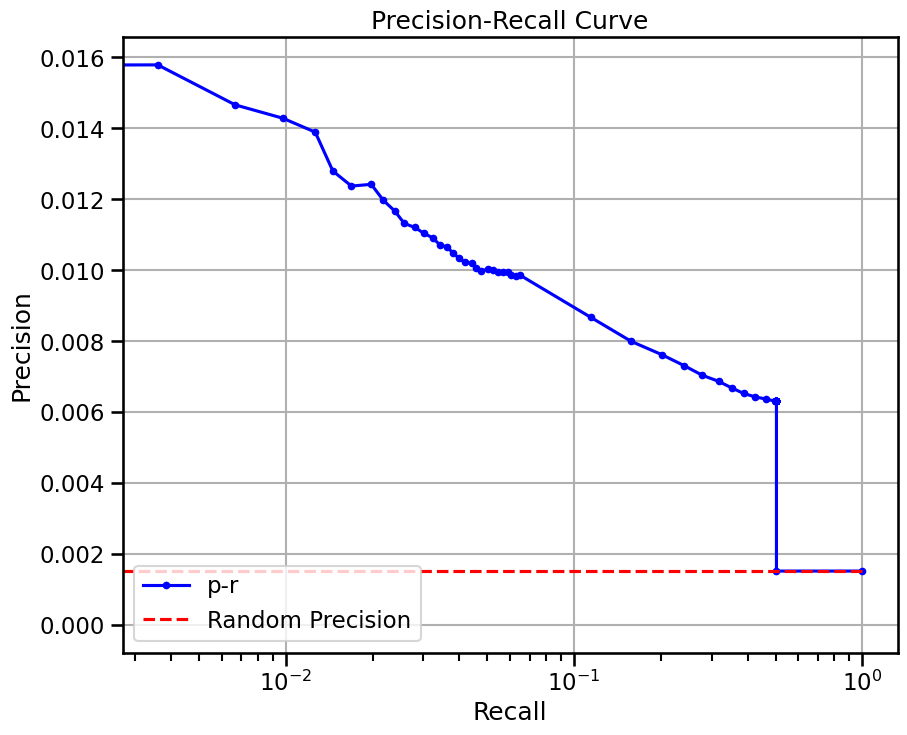

In [11]:
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_tf_han_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.3110521578473637 
recall:  0.1264418725567602 
random precision: 0.25366732938308756


  0%|          | 0/128 [00:00<?, ?it/s]

 47%|████▋     | 60/128 [00:00<00:00, 594.89it/s]

 94%|█████████▍| 120/128 [00:00<00:00, 594.37it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 592.66it/s]

Area Under Precision-Recall Curve (AUPRC):  0.2621239923166735
EPR: 0.7807812778526351


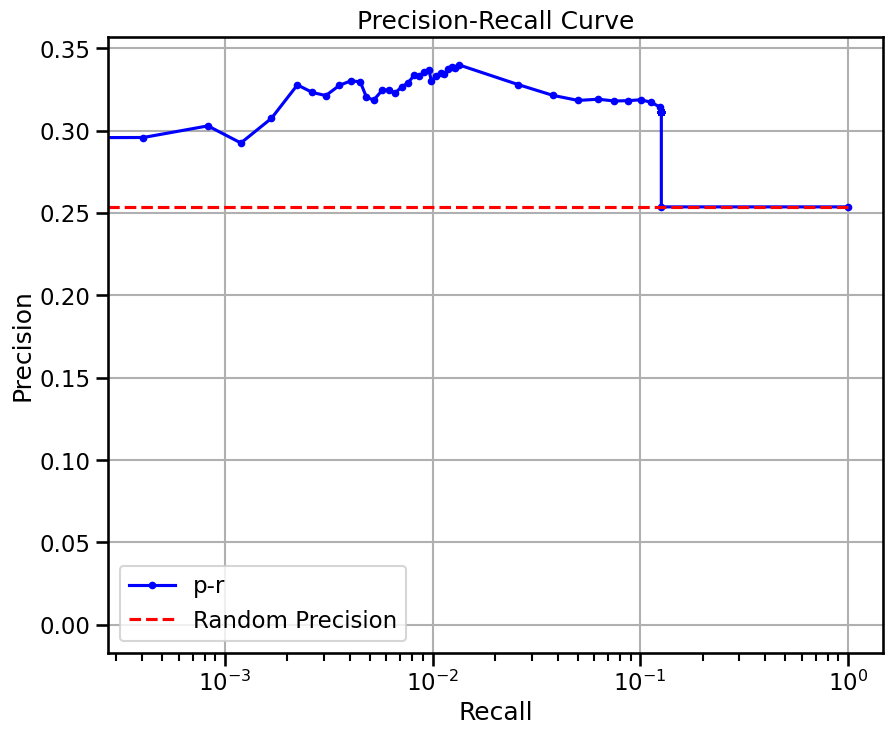

In [12]:
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['genie3_tf_han_chip'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.08761967165374394 
recall:  0.1124031007751938 
random precision: 0.07658579153672285


  0%|          | 0/128 [00:00<?, ?it/s]

 34%|███▍      | 44/128 [00:00<00:00, 434.53it/s]

 69%|██████▉   | 88/128 [00:00<00:00, 436.61it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 437.59it/s]

Area Under Precision-Recall Curve (AUPRC):  0.07749128445450512
EPR: 1.1181298298886302


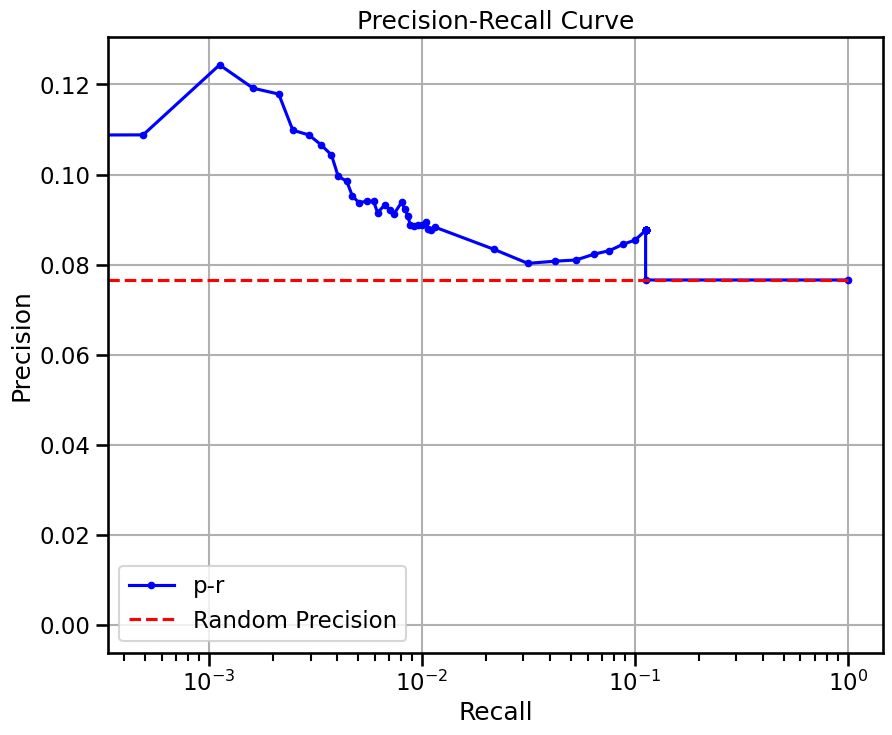

In [13]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['genie3_tf_han_ko'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

## trial with my own ESC

In [14]:
preadata = get_sroy_gt(get="mine", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 115 renamining


filtered out 0 cells, 115 renamining
Removed 0 genes.


startin QC
Seeing 104 outliers (90.43% of total dataset):


done


(GRnnData object with n_obs × n_vars = 115 × 28466
     obs: 'organism_ontology_term_id'
     var: 'ensembl_id'
     varp: 'GRN'
     with a grn of 11563 elements,
 35)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 32.97 seconds


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.03948045267489712 
recall:  0.1608171817705605 
random precision: 0.024704298988016668


  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 5515.65it/s]

Area Under Precision-Recall Curve (AUPRC):  0.028198390149234705
EPR: 2.1729800471714205


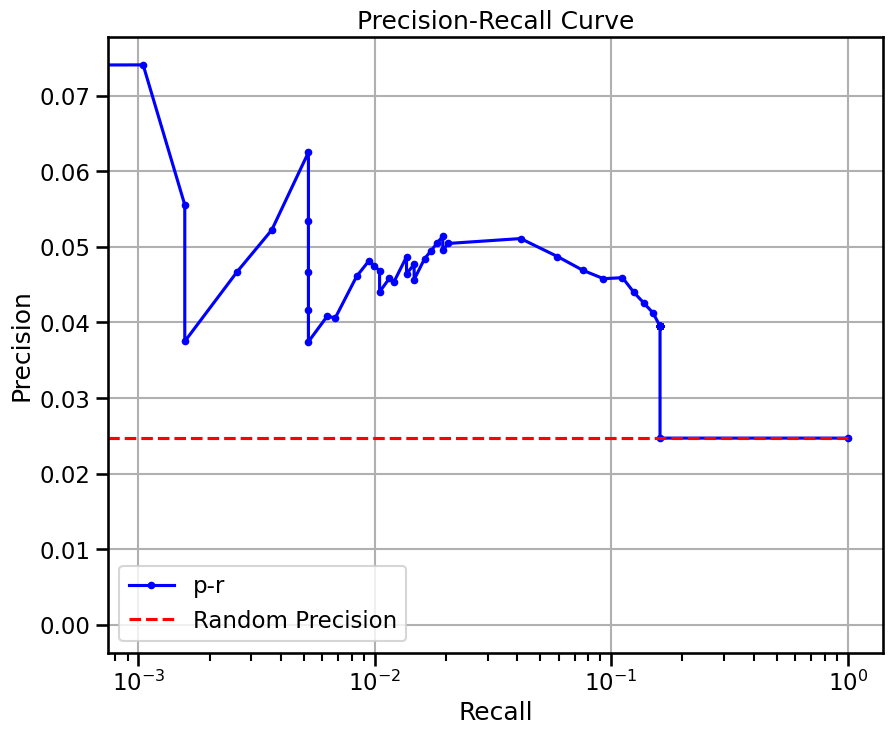

In [15]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=20,
                            regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var.index = genie_grn.var['symbol']
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_tf_mine'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


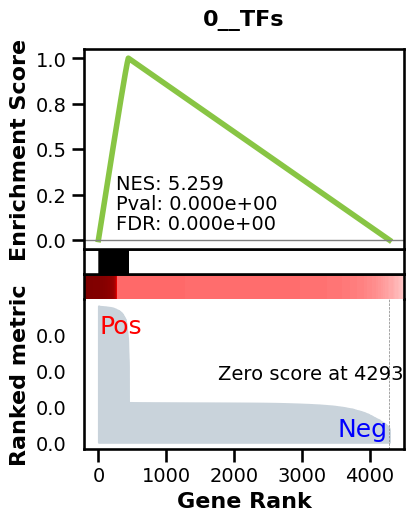

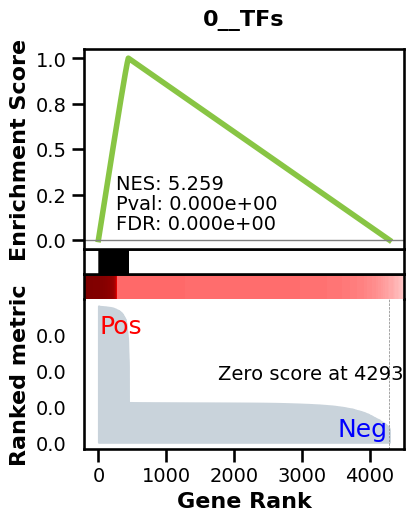

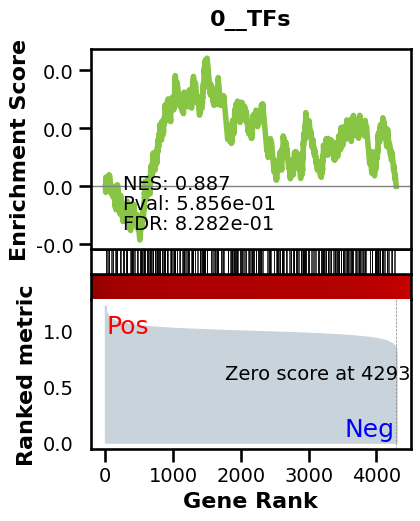

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2827 genes
intersection pct: 0.6583605030274802
precision:  0.008025132541106159 
recall:  0.6641403740011533 
random precision: 0.0015194448637656647


  0%|          | 0/128 [00:00<?, ?it/s]

  6%|▋         | 8/128 [00:00<00:01, 75.04it/s]

 12%|█▎        | 16/128 [00:00<00:01, 75.14it/s]

 19%|█▉        | 24/128 [00:00<00:01, 75.16it/s]

 25%|██▌       | 32/128 [00:00<00:01, 75.19it/s]

 31%|███▏      | 40/128 [00:00<00:01, 75.14it/s]

 38%|███▊      | 48/128 [00:00<00:01, 75.11it/s]

 44%|████▍     | 56/128 [00:00<00:00, 75.09it/s]

 50%|█████     | 64/128 [00:00<00:00, 75.08it/s]

 56%|█████▋    | 72/128 [00:00<00:00, 75.09it/s]

 62%|██████▎   | 80/128 [00:01<00:00, 75.10it/s]

 69%|██████▉   | 88/128 [00:01<00:00, 75.11it/s]

 75%|███████▌  | 96/128 [00:01<00:00, 75.12it/s]

 81%|████████▏ | 104/128 [00:01<00:00, 75.09it/s]

 88%|████████▊ | 112/128 [00:01<00:00, 75.08it/s]

 94%|█████████▍| 120/128 [00:01<00:00, 75.08it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 75.00it/s]

100%|██████████| 128/128 [00:01<00:00, 75.06it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0068633395878915085
EPR: 8.88103865934905


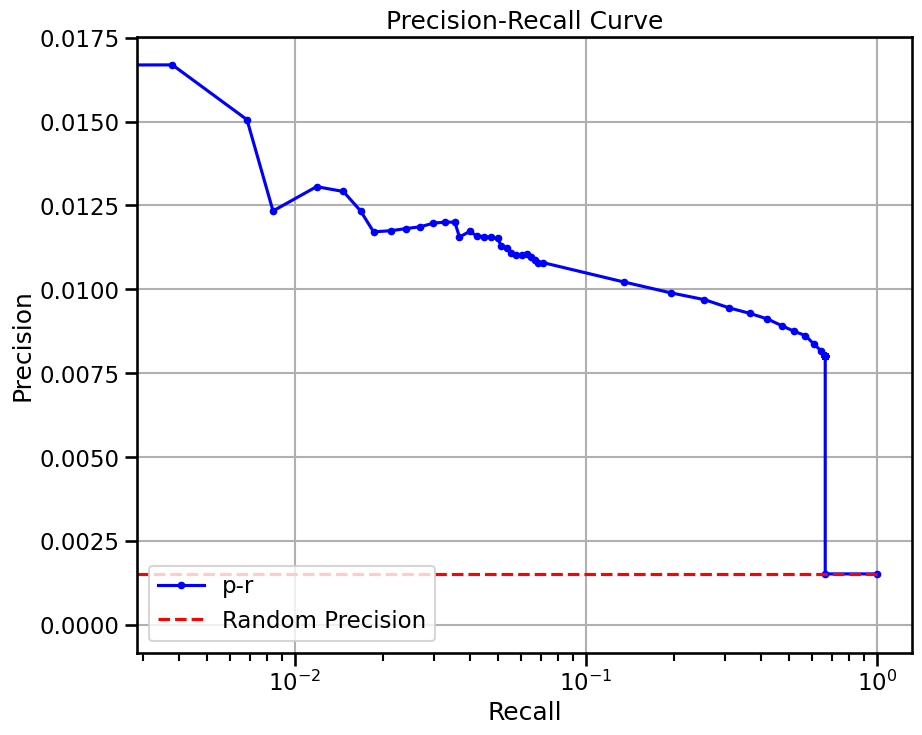

In [16]:
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_tf_mine_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 63.27 seconds


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.0279467834834104 
recall:  0.7218438973284442 
random precision: 0.024704298988016668


  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 5523.65it/s]

Area Under Precision-Recall Curve (AUPRC):  0.02860060365652824
EPR: 1.0859440629124224


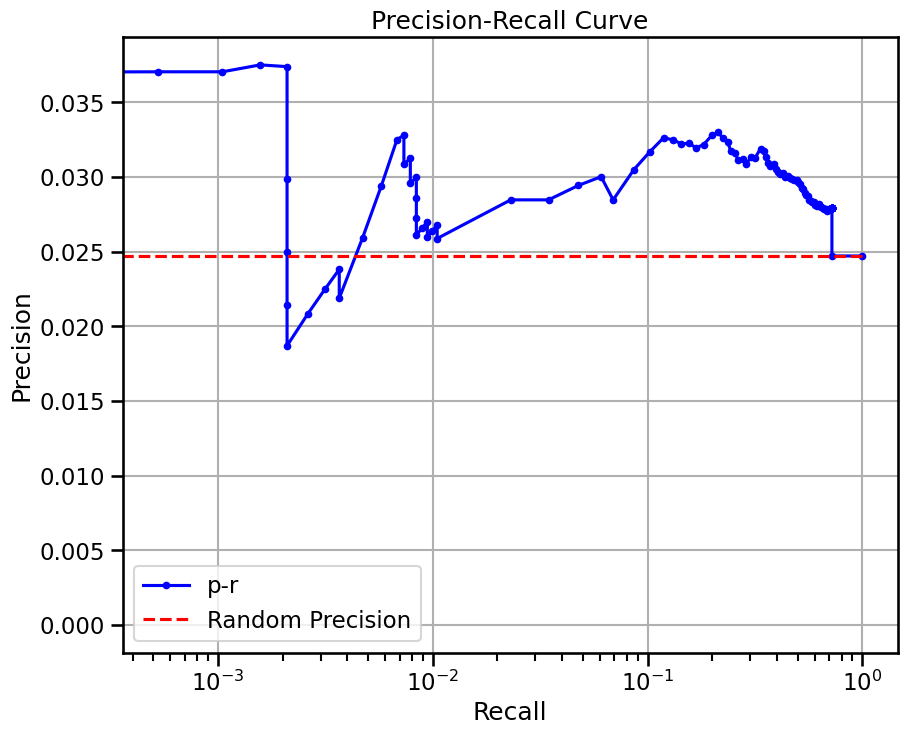

In [17]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_mine'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


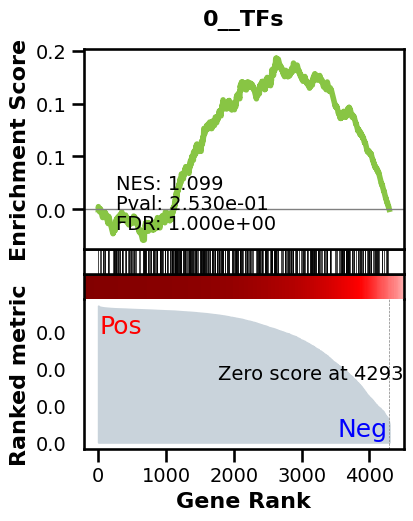

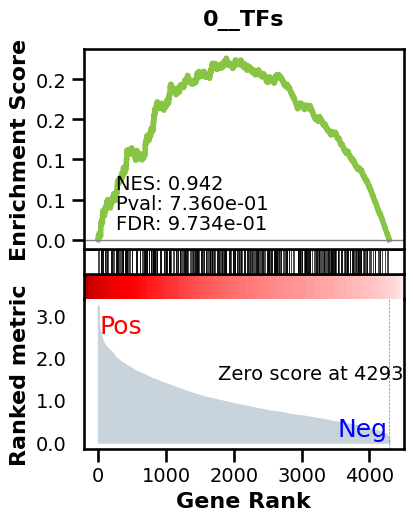

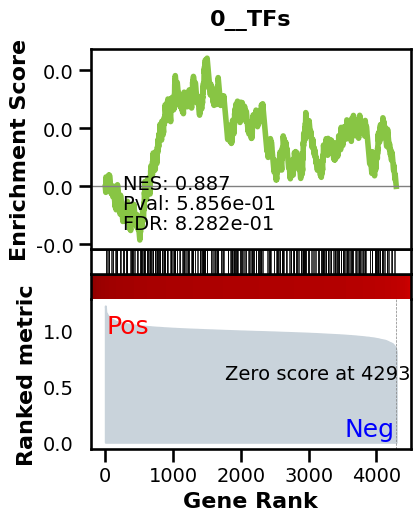

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2827 genes
intersection pct: 0.6583605030274802
precision:  0.0017314456700680625 
recall:  0.6061454815058901 
random precision: 0.0015194448637656647


  0%|          | 0/128 [00:00<?, ?it/s]

  6%|▋         | 8/128 [00:00<00:01, 76.52it/s]

 12%|█▎        | 16/128 [00:00<00:01, 76.41it/s]

 19%|█▉        | 24/128 [00:00<00:01, 76.58it/s]

 25%|██▌       | 32/128 [00:00<00:01, 76.48it/s]

 31%|███▏      | 40/128 [00:00<00:01, 76.49it/s]

 38%|███▊      | 48/128 [00:00<00:01, 76.50it/s]

 44%|████▍     | 56/128 [00:00<00:00, 76.45it/s]

 50%|█████     | 64/128 [00:00<00:00, 76.51it/s]

 56%|█████▋    | 72/128 [00:00<00:00, 76.48it/s]

 62%|██████▎   | 80/128 [00:01<00:00, 76.43it/s]

 69%|██████▉   | 88/128 [00:01<00:00, 76.52it/s]

 75%|███████▌  | 96/128 [00:01<00:00, 76.45it/s]

 81%|████████▏ | 104/128 [00:01<00:00, 76.53it/s]

 88%|████████▊ | 112/128 [00:01<00:00, 76.47it/s]

 94%|█████████▍| 120/128 [00:01<00:00, 76.57it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 76.45it/s]

100%|██████████| 128/128 [00:01<00:00, 76.46it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0017161503485220364
EPR: 1.738820781076889


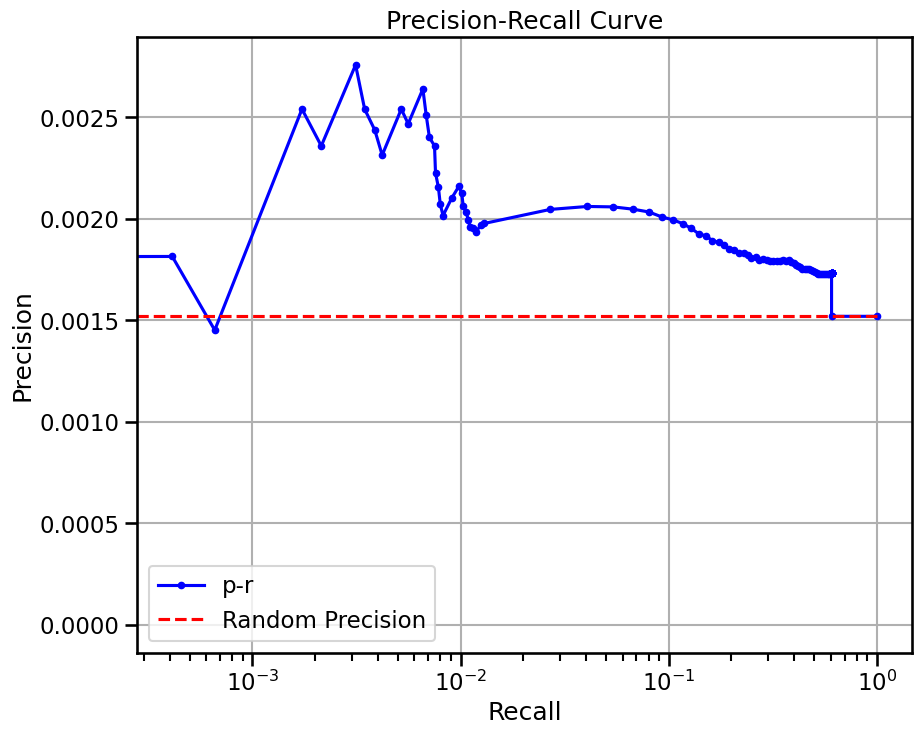

In [18]:
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_mine_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

## trial with the other two mouse dataset

In [19]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 2369 renamining


filtered out 0 cells, 2369 renamining
Removed 0 genes.


startin QC
Seeing 91 outliers (3.84% of total dataset):
done


(GRnnData object with n_obs × n_vars = 2369 × 6618
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 7162 elements,
 31)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads


Elapsed time: 75.88 seconds


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.04226938068427891 
recall:  0.09752198241406874 
random precision: 0.04047724974721941


  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2695.50it/s]

Area Under Precision-Recall Curve (AUPRC):  0.042368632892678136
EPR: 1.2206217101854266


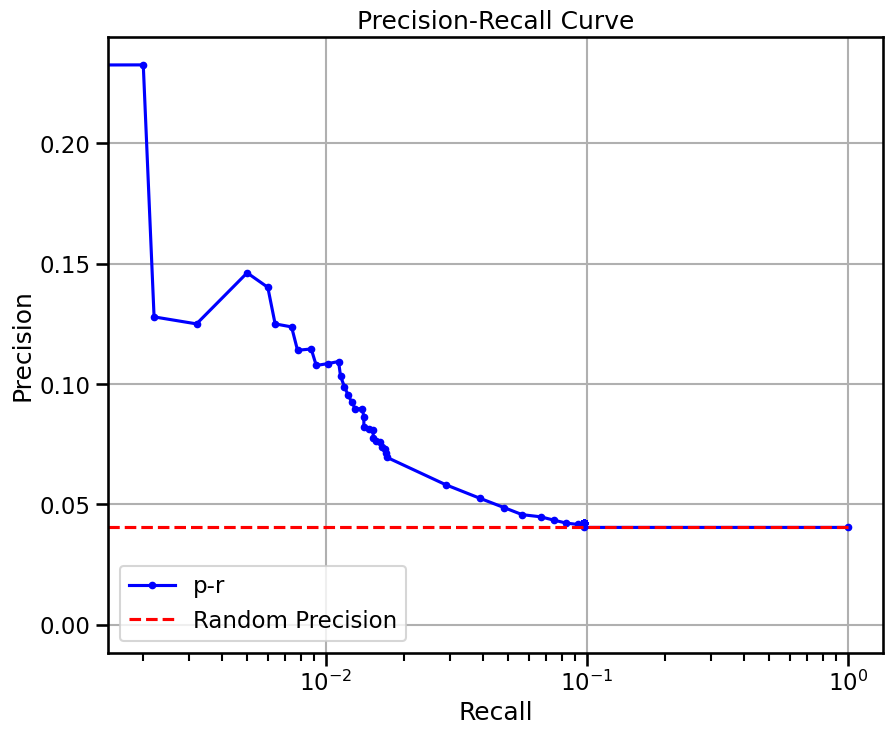

In [20]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=32,
                            regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_tf_tran'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.21807607090103398 
recall:  0.7748983073087521 
random precision: 0.1988584102547376


  0%|          | 0/128 [00:00<?, ?it/s]

 70%|██████▉   | 89/128 [00:00<00:00, 887.20it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 884.18it/s]

Area Under Precision-Recall Curve (AUPRC):  0.2291119909587641
EPR: 1.4766262048123415


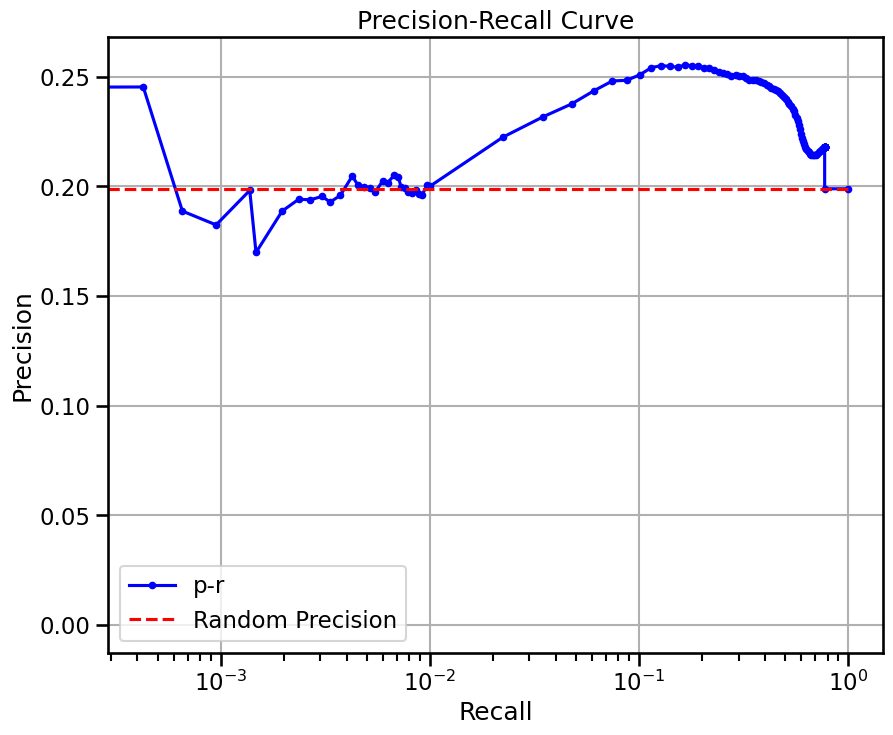

In [21]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_tf_tran_chip'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.09365313962255119 
recall:  0.764830922595778 
random precision: 0.07958310647896087


  0%|          | 0/128 [00:00<?, ?it/s]

 39%|███▉      | 50/128 [00:00<00:00, 495.87it/s]

 78%|███████▊  | 100/128 [00:00<00:00, 495.72it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 494.81it/s]

Area Under Precision-Recall Curve (AUPRC):  0.08242784708380184
EPR: 0.9768210945869907


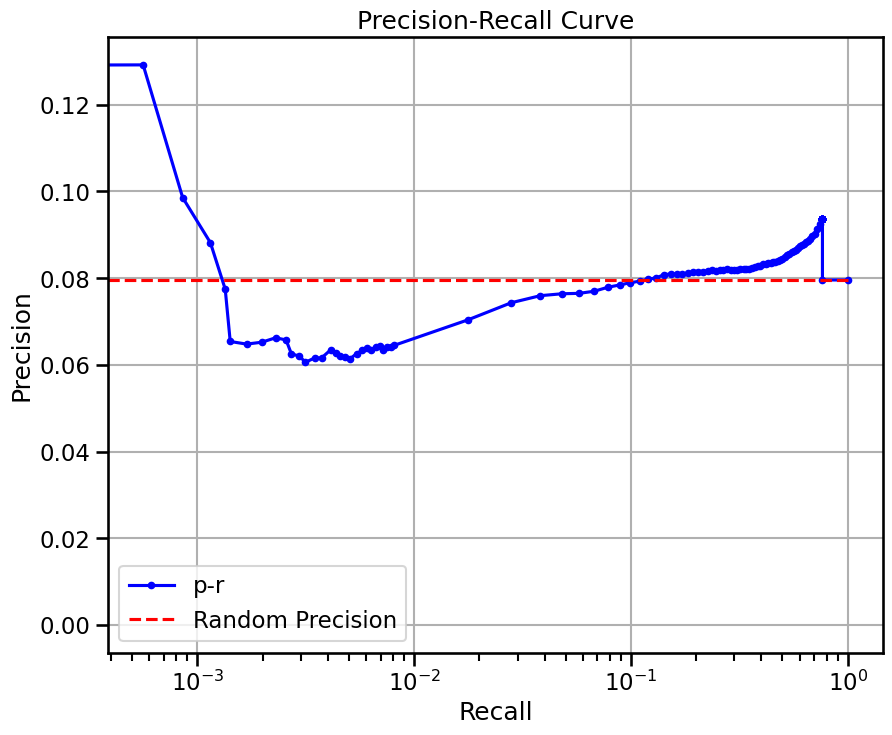

In [22]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['genie3_tf_tran_ko'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 365.53 seconds


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.06508251488282132 
recall:  0.5697566458170445 
random precision: 0.07958310647896087


  0%|          | 0/128 [00:00<?, ?it/s]

 38%|███▊      | 48/128 [00:00<00:00, 477.52it/s]

 75%|███████▌  | 96/128 [00:00<00:00, 477.42it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 477.12it/s]

Area Under Precision-Recall Curve (AUPRC):  0.07366483425230348
EPR: 0.9743024438020789


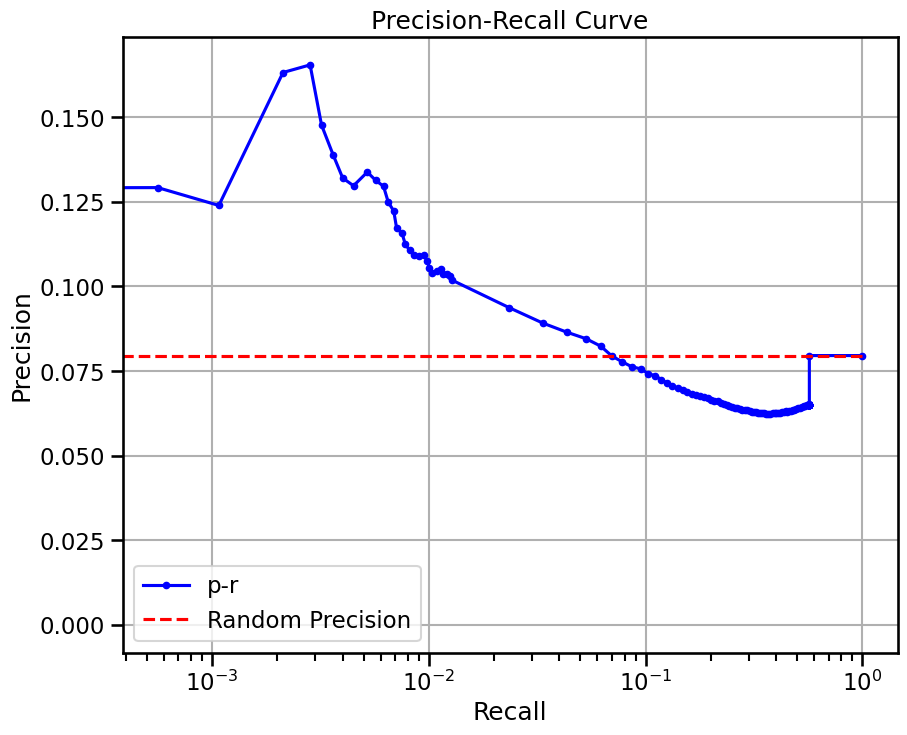

In [23]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_tran'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.19429942296717465 
recall:  0.6031032672877575 
random precision: 0.1988584102547376


  0%|          | 0/128 [00:00<?, ?it/s]

 67%|██████▋   | 86/128 [00:00<00:00, 850.71it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 847.65it/s]

Area Under Precision-Recall Curve (AUPRC):  0.1972164610111044
EPR: 0.9496766892016936


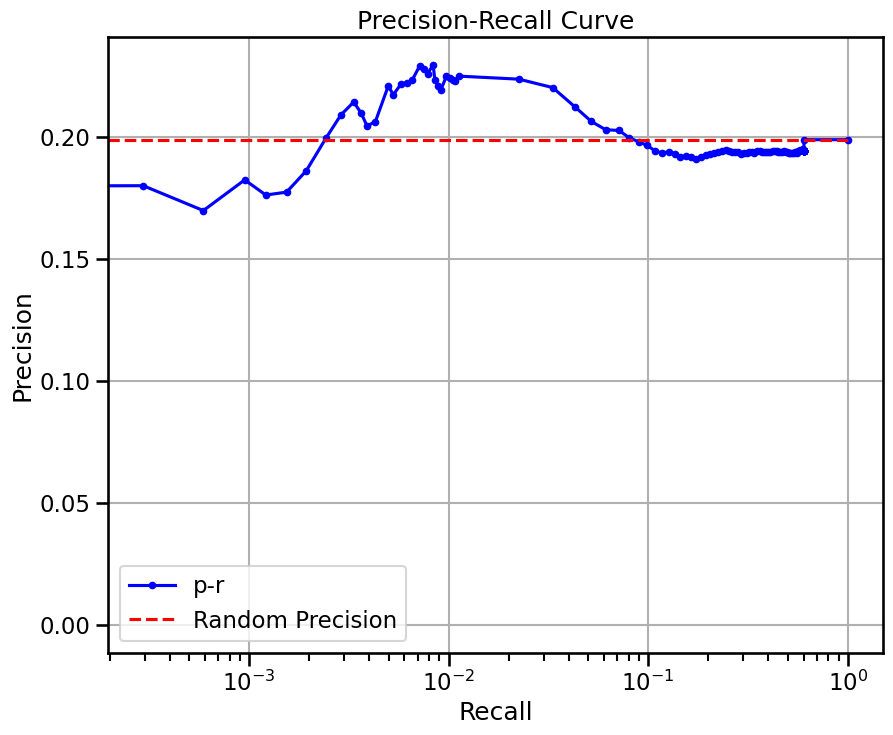

In [24]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['genie3_tran_chip'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.06508251488282132 
recall:  0.5697566458170445 
random precision: 0.07958310647896087


  0%|          | 0/128 [00:00<?, ?it/s]

 38%|███▊      | 48/128 [00:00<00:00, 479.72it/s]

 75%|███████▌  | 96/128 [00:00<00:00, 479.76it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 479.49it/s]

Area Under Precision-Recall Curve (AUPRC):  0.07366483425230348
EPR: 0.9743024438020789


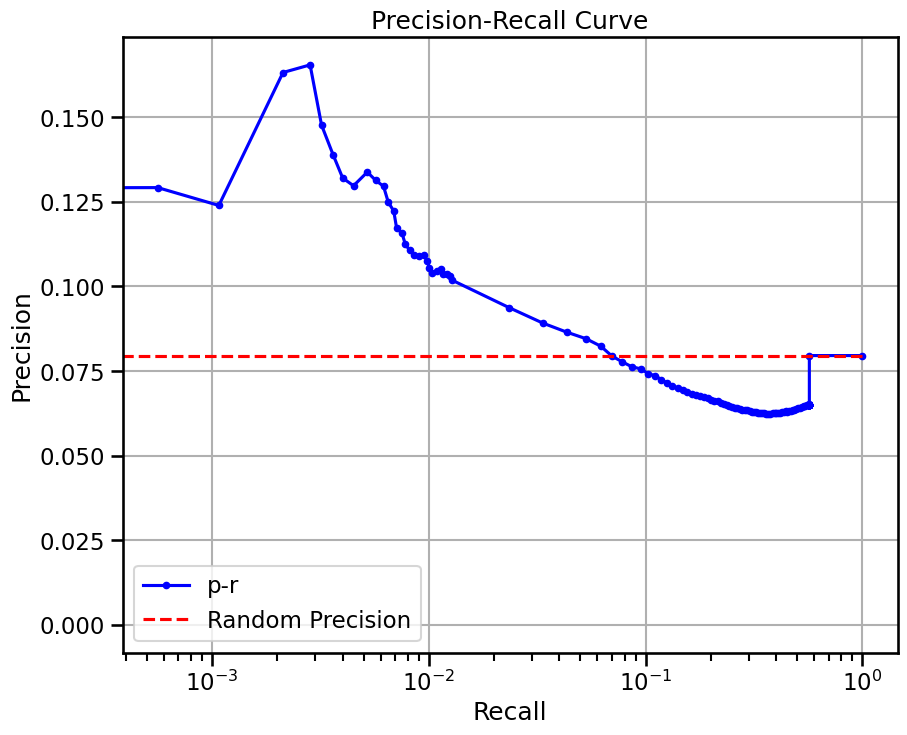

In [25]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['genie3_tran_ko'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

# zhao

In [26]:
preadata = get_sroy_gt(get="zhao", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 36199 renamining


filtered out 0 cells, 36199 renamining


Removed 0 genes.


startin QC


Seeing 828 outliers (2.29% of total dataset):


done


(GRnnData object with n_obs × n_vars = 36199 × 8442
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 9019 elements,
 34)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 78.20 seconds


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.08111070515162587 
recall:  0.16171917683482062 
random precision: 0.05307057390833704


  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2648.87it/s]

Area Under Precision-Recall Curve (AUPRC):  0.05770365176310448
EPR: 1.6154999563618737


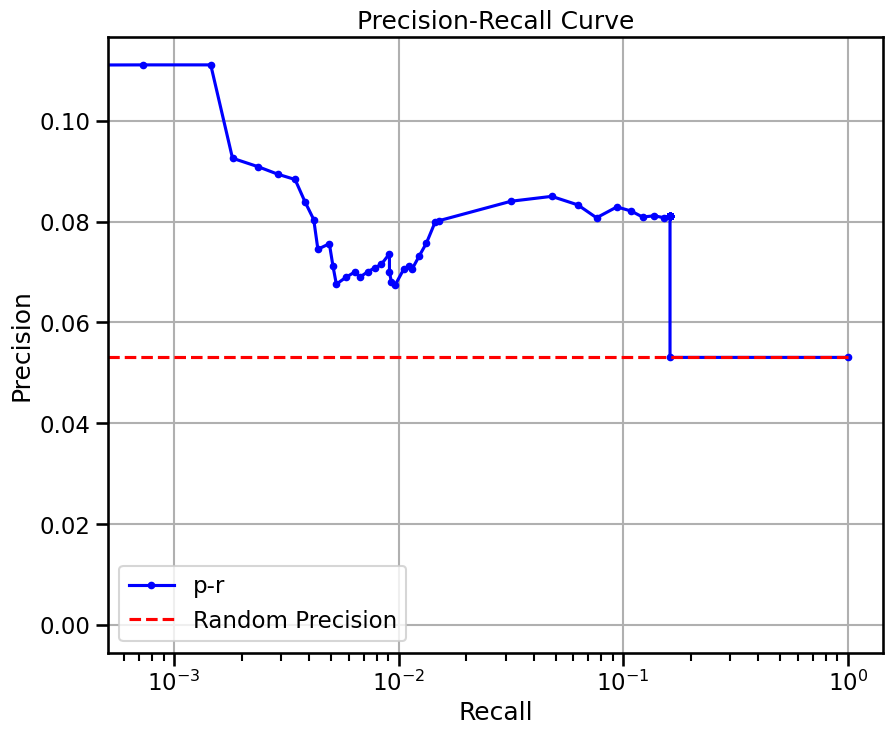

In [27]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=20,
                            regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_tf_zhao'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads


Elapsed time: 236.98 seconds


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.05903627114065759 
recall:  0.716445091968676 
random precision: 0.05307057390833704


  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 2696.83it/s]

Area Under Precision-Recall Curve (AUPRC):  0.05793820110953674
EPR: 1.0561487266231406


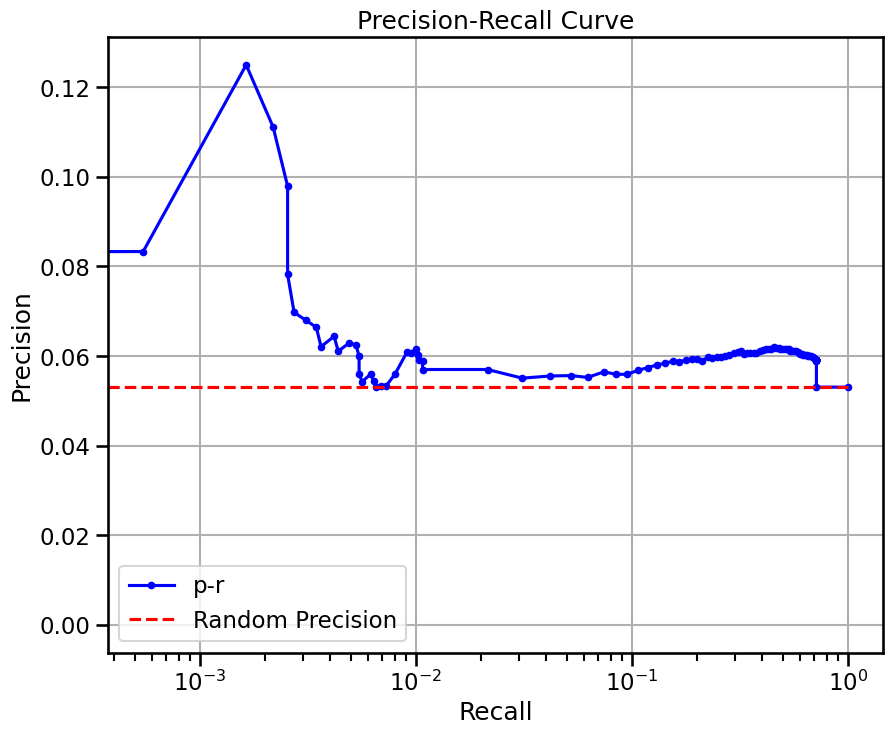

In [28]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_zhao'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [29]:
metrics

{'genie3_han': {'precision': 0.029342280960043824,
  'recall': 0.8544366899302094,
  'rand_precision': 0.027392895508257013,
  'auprc': 0.02915976390645599,
  'epr': 1.4406568461077904},
 'genie3_han_base': {'enriched_terms_Targets': ['celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Retinal pigment epithelial cells',
   'celltype.gmt__Myofibroblasts',
   'celltype.gmt__Merkel cells',
   'celltype.gmt__Radial glial cells',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__Plasma B cells',
   'celltype.gmt__Memory B cells',
   'celltype.gmt__Naive B cells',
   'celltype.gmt__HSC/MPP cells',
   'celltype.gmt__Non-classical monocytes',
   'celltype.gmt__Pro-B cells',
   'celltype.gmt__Pericytes',
   'celltype.gmt__Pre-B cells'],
  'significant_enriched_TFtargets': 11.320754716981131,
  'precision': 0.0015467340286693517,
  'recall': 0.7476461265964389,
  'rand_precision': 0.0015171100940786458,
  'auprc': 0.0016742583517634193,
  'epr': 1.5

In [30]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    elif k.split('_')[-1] == "ko":
        res.append([k.split('_')[-2]+"_ko", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    elif k.split('_')[-1] == "chip":
        res.append([k.split('_')[-2]+"_chip", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,han,1.440657,0.029160,0.027393,False
1,han_chip,1.213645,0.276646,0.253667,False
2,han_ko,1.118130,0.077491,0.076586,True
3,han,1.118130,0.077491,0.076586,True
4,han_chip,0.780781,0.262124,0.253667,True
5,mine,2.172980,0.028198,0.024704,True
6,mine,1.085944,0.028601,0.024704,False
7,tran,1.220622,0.042369,0.040477,True
8,tran_chip,1.476626,0.229112,0.198858,True
9,tran_ko,0.976821,0.082428,0.079583,True


In [31]:
df2[:4]

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,han,1.507782,0.001674,0.001517,11.320755,False,False
1,han,9.031160,0.004685,0.001517,15.094340,True,True
2,mine,8.881039,0.006863,0.001519,0.000000,True,True
3,mine,1.738821,0.001716,0.001519,0.000000,False,False
